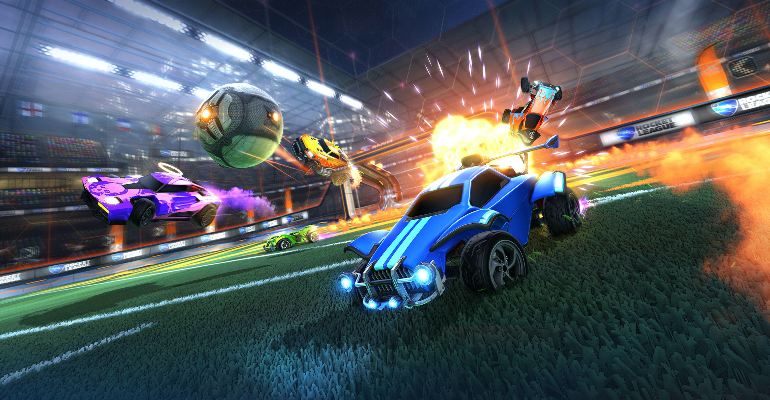

In [20]:
from IPython.display import Image
Image(filename='./Asset/RL.png') 

## **ABOUT THE DATA**
### Author: 
- Romain Mathonat - University de Lyon, CNRS, INSA Lyon (romain.mathonat@gmail.com)
- Citations: *Mathonat, R. (2020). Rocket League Skillshots [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5S035.*

### License: 
- This dataset is licensed under a **Creative Commons Attribution 4.0 International (CC BY 4.0)** license that is required upon being uploaded to **Kaggle**. \
*This allows for the sharing and adaptation of the datasets for any purpose, provided that the appropriate credit is given.*

### Source: 
- This dataset originated from the hit video game **'Rocket League'** where a football game is made up of cars!  
> https://archive.ics.uci.edu/dataset/858/rocket+league+skillshots?fbclid=IwY2xjawF6sRhleHRuA2FlbQIxMAABHV2H_iiCyHk8nsO0Ij3LK_YWD085RtxUgMpYXgYMktCR-jb9z2tjzos18Q_aem_kCpb9nymBjcgdaWgx8Dzew

# GLOBAL VARIABLES

In [21]:
DATA_PATH = './Data/rocket_league_skillshots.data'

# LIBRARIES

In [22]:
# Data manipulation
import pandas as pd
import numpy as np
from collections import defaultdict, Counter

# Models implementation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## **Importing the Data:**
- This section import the data and read them as `lines` for restructuring.

In [23]:
# Read the data from the file
with open(DATA_PATH, 'r') as file:
    lines = file.readlines()

# Initialize variables
data_blocks = defaultdict(list) # including data class and values of all features
current_class = None # class of the data_block

## **Exploring the Data:**
This section involves exploring the dataset to understand its structure, detect potential issues, and prepare it for analysis.

### Key Tasks:
1. Restructuring the data into a dataframe with an extra `Class`.
2. Identify rows, columns, and general structure.
3. Check for duplicate or missing data
4. Examine the distribution of numerical and categorical columns.
5. Ensure data types are appropriate.
6. Basic visualizations.

In [24]:
# --------------- Parsing the dataset into structured format ---------------
# Iterate through each line to categorize by class
for line in lines[1:]:  # Skip the header line
    line = line.strip()
    if line.isdigit() or (line.startswith('-') and line[1:].isdigit()):
        current_class = int(line)
    elif current_class is not None:
        data_blocks[current_class].append(list(map(float, line.split())))

# Convert each class block into a dataframe
dfs = {cls: pd.DataFrame(data, columns=lines[0].strip().split()) for cls, data in data_blocks.items()}

# Create a unified dataframe with an additional 'Class' column
combined_df = pd.concat([df.assign(Class=cls) for cls, df in dfs.items()], ignore_index=True)

# Display the first few rows of the combined dataframe
combined_df.head()

,BallAcceleration,Time,DistanceWall,DistanceCeil,DistanceBall,PlayerSpeed,BallSpeed,up,accelerate,slow,goal,left,boost,camera,down,right,slide,jump,Class
0,1636.798772,0.000000,3498.01,2012.98,299.668270,104267.426232,99035.849338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,6
1,3198.029397,0.138893,3494.08,2012.98,229.896780,124248.031988,102233.878734,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,6
2,0.000000,0.173617,3494.08,2012.98,237.350599,124248.031988,102968.358990,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6
3,9914.766242,0.312510,3500.08,2012.98,151.880921,115248.016009,112883.125231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6
4,5907.747166,0.625019,3521.65,2013.00,154.556104,125091.256173,118790.872398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,6


In [25]:
# 1. Check for duplicate and missing data
duplicate_count = combined_df.duplicated().sum()
missing_data_count = combined_df.isnull().sum()

# 2. Examine the distribution of numerical and categorical columns
numerical_columns = combined_df.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = combined_df.select_dtypes(include=['object']).columns

numerical_summary = combined_df[numerical_columns].describe()

# 3. Check data types
data_types = combined_df.dtypes

# Display results
duplicate_count, missing_data_count, numerical_summary, data_types

(15,
 BallAcceleration    0
 Time                0
 DistanceWall        0
 DistanceCeil        0
 DistanceBall        0
 PlayerSpeed         0
 BallSpeed           0
 up                  0
 accelerate          0
 slow                0
 goal                0
 left                0
 boost               0
 camera              0
 down                0
 right               0
 slide               0
 jump                0
 Class               0
 dtype: int64,
        BallAcceleration         Time   DistanceWall  DistanceCeil  \
 count       6892.000000  6892.000000    6892.000000   6892.000000   
 mean       -3919.343775     2.104198    3814.275050   1654.879848   
 std        46931.140062     1.748528   14439.166026    565.840926   
 min      -319123.135620     0.000000       0.000000      0.070000   
 25%        -2166.687659     0.763877    1084.260000   1331.655000   
 50%          -27.293854     1.701767    3101.885000   1959.010000   
 75%         1054.076610     3.096547    3744.822500 

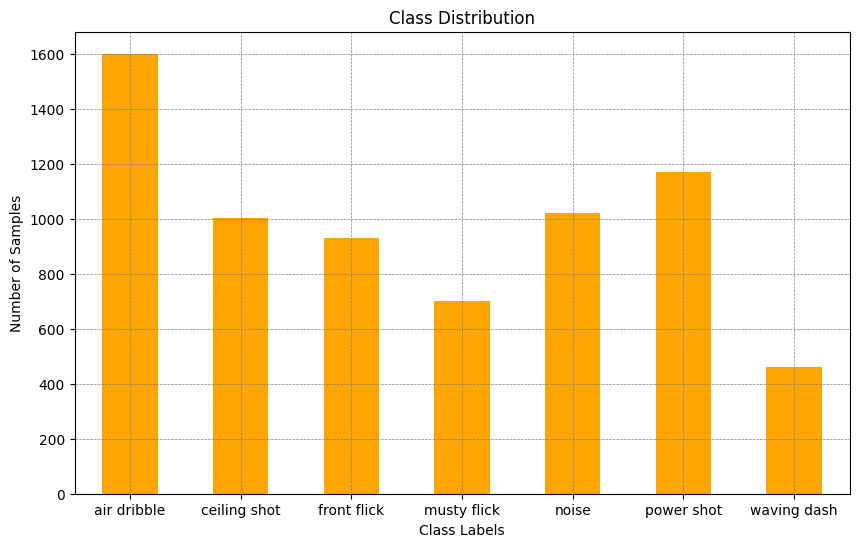

In [26]:
# Define the lists for classes
classes_labels = {-1: 'noise', 
                  1: 'ceiling shot', 
                  2: 'power shot', 
                  3: 'waving dash', 
                  5: 'air dribble', 
                  6: 'front flick', 
                  7: 'musty flick'}

# Display class distribution
class_distribution = combined_df['Class'].value_counts()

# Match the class labels with the class distribution
class_distribution.index = class_distribution.index.map(classes_labels)

# Plot class distribution
plt.figure(figsize=(10, 6))
class_distribution.sort_index().plot(kind='bar', color='orange')
plt.title('Class Distribution')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.show()

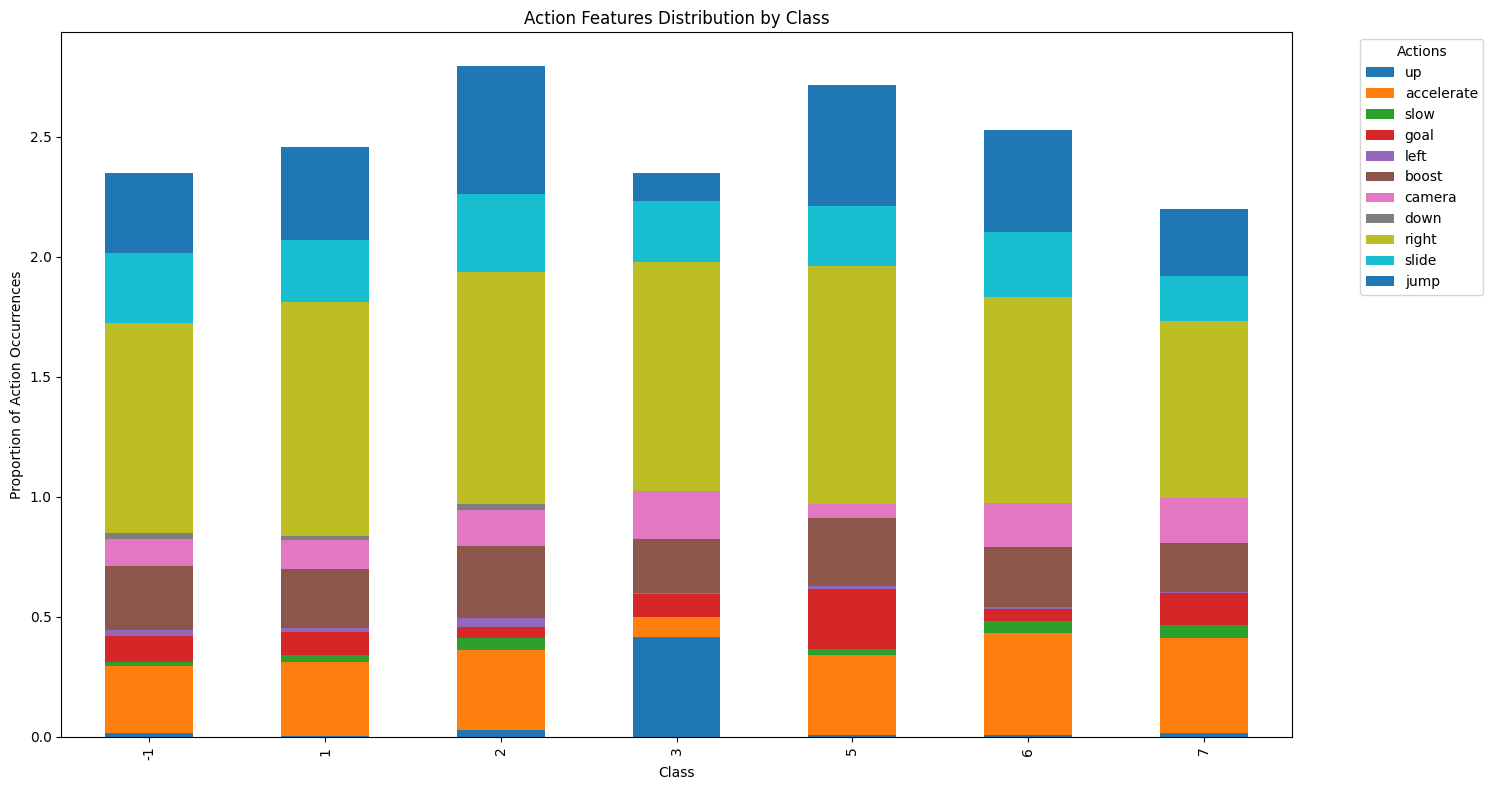

In [27]:
# Define the lists for measurements and actions
measurement_features = ['BallAcceleration', 'Time', 'DistanceWall', 'DistanceCeil',
                        'DistanceBall', 'PlayerSpeed', 'BallSpeed']

action_features = ['up', 'accelerate', 'slow', 'goal', 'left', 'boost', 'camera', 
                   'down', 'right', 'slide', 'jump']

# Plot stacked bar charts for action features
action_summary = combined_df.groupby('Class')[action_features].mean()

# Plot action features as a stacked bar chart
action_summary.plot(kind='bar', stacked=True, figsize=(15, 8))
plt.title('Action Features Distribution by Class')
plt.xlabel('Class')
plt.ylabel('Proportion of Action Occurrences')
plt.legend(title='Actions', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## **Initial Observations**

### Data shape: 
- $19$ columns of **attributes**.
- $7191$ rows of **entries**. 

### Data structure:
The dataset has the following structure:
- **Class Labels**: A line with only 1 interger that specifies the class label for the upcoming block of data (e.g., 6).
- **Data Blocks**: Each block consists of multiple rows of numerical data followed by another class label.

#### Classes:
- There are $7$ classes, `-1` representing noise (composed of failed figures and random moves): 
    + `-1`: noise
    + `1`: ceiling shot
    + `2`: power shot
    + `3`: waving dash
    + `5`: air dribble
    + `6`: front flick
    + `7`: musty flick

### Features: There are $18$ features per class. WHERE:
- **Measurements (Continuous Variables)**: These columns represent quantitative measurements related to the ball, player, and environment:
    1. `BallAcceleration`: Acceleration of the ball.
    2. `Time`: Time elapsed.
    3. `DistanceWall`: Distance to the wall.
    4. `DistanceCeil`: Distance to the ceiling.
    5. `DistanceBall`: Distance between player and ball.
    6. `PlayerSpeed`: Speed of the player.
    7. `BallSpeed`: Speed of the ball.
- **Actions (Categorical/Binary Variables)**: These columns represent actions taken by the player, typically with binary values (0 or 1): 
    1. `up`: Action - move up. 
    2. `accelerate`: Action - accelerate. 
    3. `slow`: Action - slow. 
    4. `goal`: Action - goal attempt. 
    5. `left`: Action - move left. 
    6. `boost`: Action - boost. 
    7. `camera`: Action - camera adjustment. 
    8. `down`: Action - move down. 
    9. `right`: Action - move right. 
    10. `slide`: Action - slide. 
    11. `jump`: Action - jump.

### Data Quality and Distribution Analysis:
- Duplicates: There are 15 duplicate rows in the dataset.
- Missing Data: No missing values in any of the columns.
- Numerical Columns:
    + All columns appear to be numerical (float or int).
    + Descriptive statistics reveal the range, mean, and distribution of values for each feature.
- Data Types: All columns have appropriate data types (float64 for features, int64 for the class label).
- Class distribution: Class `5 - air dribble` is the most used move in the dataset.


## **Asking Meaningful Questions:**
This section defines the research questions that guide the analysis.

### Questions:
1. **How does the frequency and timing of boost usage affect a player's performance and contribution to the team's success in Rocket League?**
2. **What are the key factors that influence the success rate of aerial shots in Rocket League?**
3. **Can we predict if a goal attempt will be successful?**

These questions aim to provide actionable insights for gameplay analytics and player skill evaluation.

## **QUESTION 1: How does the frequency and timing of boost usage affect a player's performance and contribution to the team's success in Rocket League?**

### **Model Suggestion:**
1. **Random Forest Classifier**
   - **Why**: This model handles high-dimensional data well and can identify non-linear relationships between boost usage patterns and performance metrics.
   - **Feature Importance**: It can provide insights into which aspects of boost usage (e.g., frequency, timing) have the most impact on player success.
   - **Interpretability**: Easy to interpret through feature importance scores and visualizations.

2. **Logistic Regression**
   - **Why**: Suitable for binary classification tasks (e.g., success vs. failure) and provides a simple, interpretable model.
   - **Insights**: Useful for understanding how individual boost-related features contribute to the probability of success.

3. **Time Series Analysis (e.g., LSTM or GRU)**
   - **Why**: If the dataset includes sequential data on boost usage over time, a time-series model can capture the impact of boost usage timing on performance.
   - **Sequential Patterns**: Can reveal insights into how boost usage patterns evolve during gameplay and affect overall performance.

4. **Gradient Boosting Models (e.g., XGBoost or LightGBM)**
   - **Why**: These models are powerful for structured data and can handle complex relationships between features.
   - **Performance**: Often achieve high accuracy and can manage feature interactions effectively.


### **Benefits of finding the answer:**
1. **Skill Improvement**
   - Helps players optimize boost usage strategies, such as when to conserve or expend boost, to enhance individual performance.

2. **Game Strategy**
   - Coaches and analysts can develop more effective team strategies by understanding how boost usage affects overall contribution to success.
   - Teams can allocate roles and responsibilities based on boost efficiency patterns.

3. **Performance Metrics**
   - Provides a quantitative way to measure and evaluate player contributions.
   - Helps in identifying key metrics for ranking players or assessing their effectiveness during matches.

4. **Training Programs**
   - Insights can be used to design targeted training programs to improve boost management skills.
   - Personalized feedback for players to help them adjust their boost usage in different game situations.

5. **In-Game Decision Making**
   - Enhances real-time decision-making by understanding the optimal timing for boost usage to maximize performance.

## **Preprocessing and Analysis:**
### **Preprocessing Steps:**
1. **Parse the Dataset:**  Read and process the dataset file to categorize each data block by its Class. The dataset is not in a tabular format initially, so parsing helps convert it into a structured DataFrame.
2. **Data Cleaning:** Handle missing values in the dataset. Ensures that missing values do not interfere with model training or analysis.
3. **Feature Scaling:** Standardize numerical features to ensure they have a mean of 0 and a standard deviation of 1. Ensures that features are on the same scale, which is important for many machine learning algorithms.
4. **Feature Selection:** Identify relevant features, focusing on boost usage and gameplay metrics. Prepares the data for scaling and future analysis (e.g., modeling). 
5. **Feature Standardization:** Standardizing features like boost, accelerate, and Time ensures they are on the same scale, which is essential for models like Random Forest. This helps the model interpret features consistently and improves performance.

In [28]:
# Feature Selection
# Separate features (X) and target (y)
X = combined_df.drop(columns=['Class'])
y = combined_df['Class']

# Feature Scaling
# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert the scaled features back into a DataFrame for easier analysis
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Display the first few rows of the cleaned and scaled data
print(X_scaled_df.head())

# Display the first few rows of the target variable
print(y.head())

   BallAcceleration      Time  DistanceWall  DistanceCeil  DistanceBall  \
0          0.118398 -1.203499     -0.021905      0.632910     -0.523640   
1          0.151667 -1.124058     -0.022177      0.632910     -0.566399   
2          0.083519 -1.104198     -0.022177      0.632910     -0.561831   
3          0.294796 -1.024758     -0.021761      0.632910     -0.614210   
4          0.209409 -0.846018     -0.020268      0.632945     -0.612571   

   PlayerSpeed  BallSpeed        up  accelerate      slow      goal      left  \
0    -0.945730  -0.349306 -0.204633   -0.691618 -0.187472 -0.374824 -0.126766   
1    -0.537322  -0.305235 -0.204633   -0.691618 -0.187472 -0.374824 -0.126766   
2    -0.537322  -0.295113 -0.204633   -0.691618 -0.187472 -0.374824 -0.126766   
3    -0.721284  -0.158480 -0.204633   -0.691618 -0.187472 -0.374824 -0.126766   
4    -0.520087  -0.077066 -0.204633   -0.691618 -0.187472 -0.374824 -0.126766   

      boost    camera      down     right     slide      jump 

### **Analysis:**

1. **Feature Selection:** Select features related to boost usage and timing that can impact player performance.
2. **Correlation Analysis:** Compute and visualize the correlation between boost usage and other selected features using a heatmap to identify relationships.
3. **Train-Test Split:** Split the dataset into training and testing sets to prepare for model training.
4. **Model Training:** Train a Random Forest Classifier to predict player performance based on boost usage and related features.
5. **Model Evaluation:** Evaluate the trained model using metrics such as accuracy score and a classification report (precision, recall, F1-score).
6. **Feature Importance Analysis:** Identify which features (e.g., boost frequency, timing) are most important in predicting player performance.
7. **Visualization:** Visualize the feature importance scores with a bar chart to better understand the impact of boost usage on player performance.

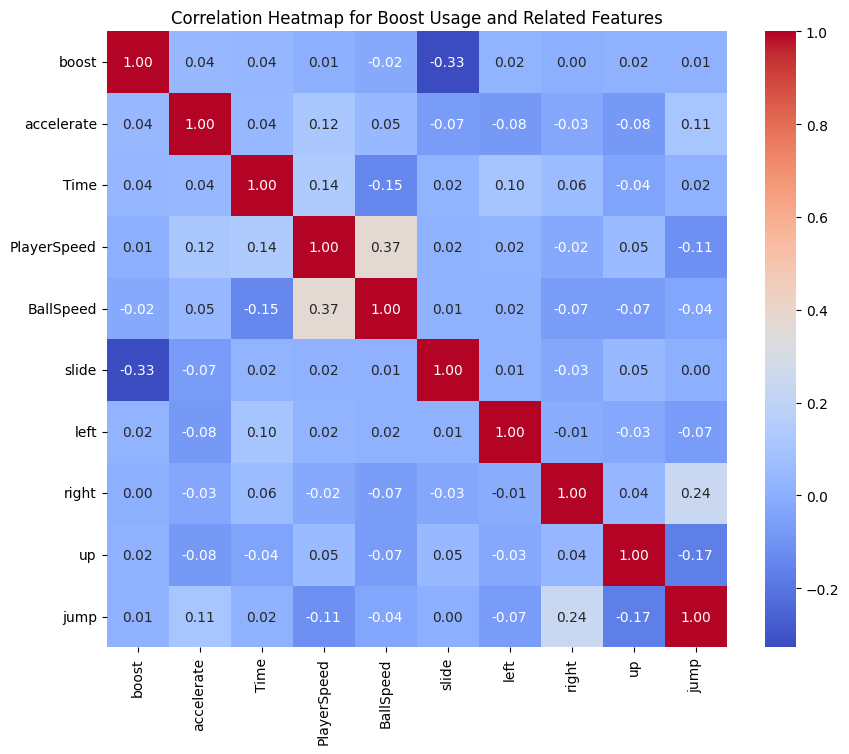

Accuracy Score: 0.5946337926033357

Classification Report:
               precision    recall  f1-score   support

          -1       0.66      0.46      0.54       218
           1       0.62      0.69      0.65       182
           2       0.58      0.68      0.62       226
           3       0.68      0.68      0.68        80
           5       0.63      0.72      0.67       326
           6       0.52      0.47      0.49       195
           7       0.46      0.39      0.42       152

    accuracy                           0.59      1379
   macro avg       0.59      0.58      0.58      1379
weighted avg       0.59      0.59      0.59      1379


Feature Importances:
 BallSpeed      0.305437
PlayerSpeed    0.286200
Time           0.272797
up             0.026025
accelerate     0.023419
slide          0.022609
boost          0.022330
jump           0.019432
right          0.016832
left           0.004919
dtype: float64


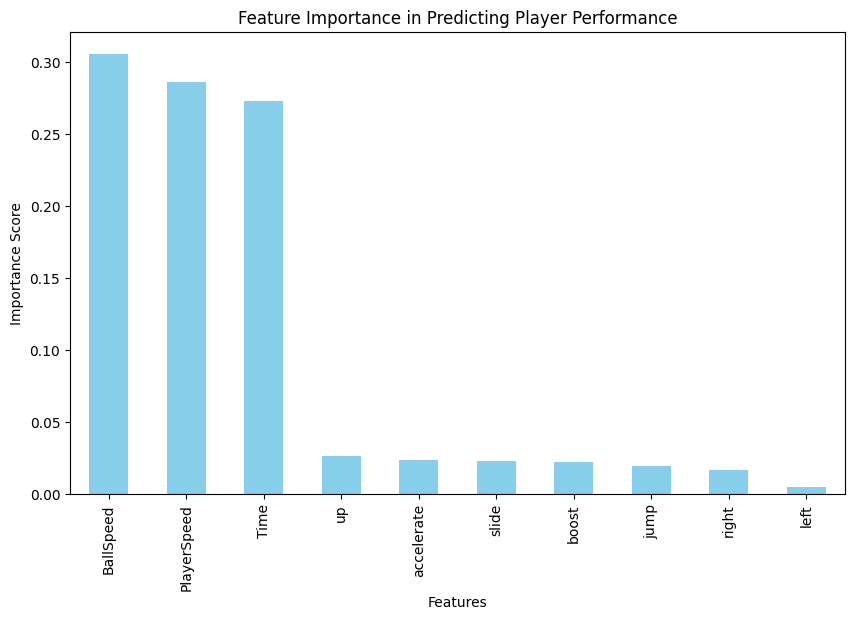

In [29]:
# Step 1: Feature Selection
features_q3 = ['boost', 'accelerate', 'Time', 'PlayerSpeed', 'BallSpeed', 'slide', 'left', 'right', 'up', 'jump']

# Create feature matrix (X) and target vector (y)
X_q3 = combined_df[features_q3]
y_q3 = combined_df['Class']

# Step 2: Correlation Analysis
plt.figure(figsize=(10, 8))
sns.heatmap(X_q3.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap for Boost Usage and Related Features")
plt.show()

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_q3, y_q3, test_size=0.2, random_state=42)

# Step 4: Model Training
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Step 5: Model Evaluation
y_pred = model.predict(X_test)
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Step 6: Feature Importance Analysis
feature_importances_q3 = pd.Series(model.feature_importances_, index=features_q3).sort_values(ascending=False)
print("\nFeature Importances:\n", feature_importances_q3)

# Step 7: Visualization of Feature Importances
plt.figure(figsize=(10, 6))
feature_importances_q3.plot(kind='bar', color='skyblue')
plt.title("Feature Importance in Predicting Player Performance")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.show()

## **QUESTION 2: What are the key factors that influence the success rate of aerial shots in Rocket League??**

### **Model Suggestion:**
- **Random Forest:** Good for feature importance analysis and handling non-linear relationships. It's a strong baseline model for classification tasks.
- **Logistic Regression:** Simple, interpretable, and effective for binary classification (e.g., success/failure).

### **Benefits of finding the answer:**
- **Skill Improvement:** Helps players understand which factors are most important for successful aerial shot, allowing them to focus on improving these areas.
- **Game Strategy:** Coaches can develop strategies that leverage these key factors to increase the success rate of aerial shots.
- **Performance Metrics:** Provides insights into the relationship between various factors and aerial shot success, which can be used to evaluate and enhance player performance.

## **Preprocessing and Analysis:**
### **Preprocessing Steps:**
- **Data Cleaning:** We need to check for missing values or any rows that might contain incorrect or incomplete data. These should be handled appropriately, either by removing or imputing values.
- **Feature Scaling:** Since we are using machine learning algorithms like Random Forest, it is important to standardize numerical features. Standardizing features ensures that each feature has a mean of 0 and a standard deviation of 1, which can help improve the model’s performance.
- **Categorical Data:** If the data contains categorical features (though this dataset seems to focus on numerical features), they would need to be converted into numerical values (e.g., using one-hot encoding).
- **Feature Selection:** We may want to select only the most relevant features for modeling, which can help improve performance and prevent overfitting.

In [30]:
# Standardize numerical columns
scaler = StandardScaler()  # Initialize StandardScaler to scale the features
numerical_features = [col for col in combined_df.columns if col not in ['Class']]  # List of feature columns

# Apply the scaler to the numerical features
combined_df[numerical_features] = scaler.fit_transform(combined_df[numerical_features])

print("Preprocessing steps completed: Missing values checked and data standardized.")

Preprocessing steps completed: Missing values checked and data standardized.


### **Data Analysis:**
**Step 1: Correlation Heatmap**
- **Purpose:** Identify relationships between features and success ```(Class)```.
- **Output:** A heatmap shows which features are most correlated with success, helping in feature selection.

**Step 2: Random Forest Model**
- **Purpose:** Train a Random Forest Classifier to predict success.
- **Process:** The dataset is split into features (```X```) and target (```y```), and 80/20 training-testing split is applied. The model learns from the training data.
- **Output:** A predictive model capable of determining success rates for aerial shots.

**Step 3: Model Evaluation**
- **Purpose:** Assess model accuracy and performance.
- **Output:** Metrics such as accuracy, precision, recall, and F1-score evaluate how well the model predicts outcomes.

**Step 4: Feature Importance**
- **Purpose:** Identify which features influence success most.
- **Output:** Ranked feature importance scores highlight key factors like ```PlayerSpeed```, ```BallAcceleration```, and ```Boost```.

**Step 5: Visualization**
- **Purpose:** Display feature importance for easy interpretation.
- **Output:** A bar chart shows the relative impact of each feature on success

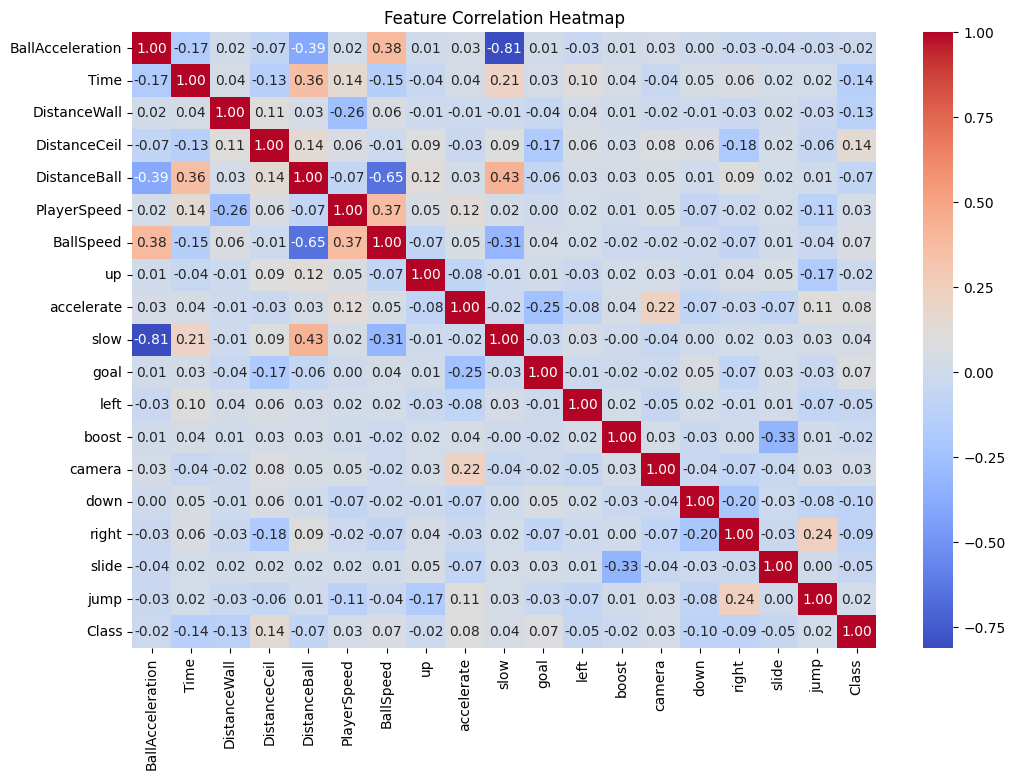

Accuracy Score: 0.7868020304568528
Classification Report:
              precision    recall  f1-score   support

          -1       0.86      0.48      0.61       218
           1       0.83      0.83      0.83       182
           2       0.79      0.94      0.86       226
           3       0.94      0.85      0.89        80
           5       0.85      0.94      0.90       326
           6       0.64      0.79      0.71       195
           7       0.66      0.57      0.61       152

    accuracy                           0.79      1379
   macro avg       0.80      0.77      0.77      1379
weighted avg       0.79      0.79      0.78      1379

Feature Importances:
DistanceCeil        0.168198
DistanceBall        0.164837
DistanceWall        0.151467
Time                0.120428
BallSpeed           0.107126
PlayerSpeed         0.106251
BallAcceleration    0.072323
up                  0.019973
jump                0.016830
accelerate          0.015427
slide               0.011438
boost

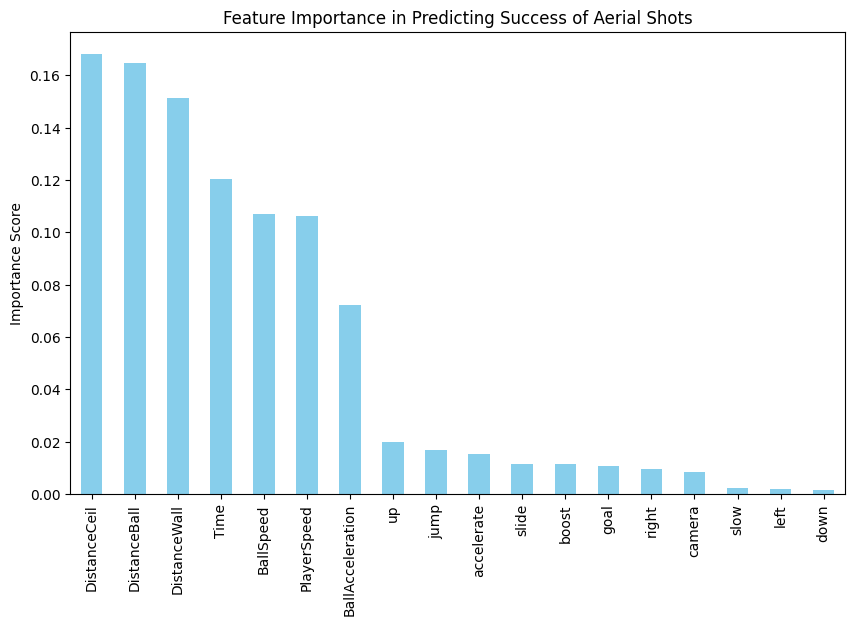

In [31]:
# Step 1: Visualize relationships between features and success (Class)
plt.figure(figsize=(12, 8))
sns.heatmap(combined_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")  # Correlation heatmap
plt.title("Feature Correlation Heatmap")
plt.show()

# Step 2: Train a model (Random Forest) to identify key factors influencing success
X = combined_df.drop(columns=['Class'])  # Features
y = combined_df['Class']  # Target variable (Class represents success)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Step 3: Evaluate model and print feature importance
y_pred = model.predict(X_test)  # Predictions on the test set
print("Accuracy Score:", accuracy_score(y_test, y_pred))  # Evaluate the model

# Print classification report to get insights on model performance
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Feature importance analysis
feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Feature Importances:")
print(feature_importances)

# Step 4: Visualize feature importances
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar', color='skyblue')
plt.title("Feature Importance in Predicting Success of Aerial Shots")
plt.ylabel("Importance Score")
plt.show()


### **Conclusion**
In conclusion, the success rate of aerial shots in Rocket League is primarily influenced by the following key factors:

1. **DistanceCeil**, **DistanceBall**, and **DistanceWall**: These factors, which relate to the positioning of the player and the ball, are the most important in determining shot success.
2. **Time**: The available time to make the shot plays a crucial role in decision-making and execution.
3. **BallSpeed**, **PlayerSpeed**, and **BallAcceleration**: These factors affect the player's ability to control and react to the ball during an aerial shot.

Other factors have much less impact on the outcome. Therefore, optimizing positioning and reaction times, along with controlling the ball's speed and acceleration, are the key strategies for improving aerial shot success.

## **QUESTION 3: Can we predict if a goal attempt will be successful?**

### Define the Problem and Objectives:
- Objective: Predict whether a goal attempt will be successful based on player, ball, and action-related features.
- Type of Problem: This is a binary classification problem where the output is:
    + `1`: Successful goal attempt.
    + `0`: Unsuccessful goal attempt.

### Model suggestion:
- Model: Classification model (e.g., Logistic Regression, Random Forest).
- Target: `goal` column (binary: 1 for goal attempt, 0 otherwise).
- Features: Measurements (BallAcceleration, DistanceBall, PlayerSpeed, BallSpeed, etc.), Actions (boost, jump, slide, etc.).

#### Why the suggested models ?
1. Random Forest:
    - Nonlinear Interactions: In Rocket League, the relationship between features (e.g., ball speed, player speed, distances) and goal success is likely nonlinear. Random Forest captures these complex interactions effectively.
    - Handles Noisy Data: The dataset contains a `noise` class (`-1`), representing failed or random moves. Random Forest is robust to such noisy data, reducing the chance of overfitting.
    - Feature Importance: In understanding goal success, knowing which factors (e.g., player speed, distance to the ball) influence outcomes is valuable. Random Forest provides insights into which features contribute most to goal success.
    - Imbalanced Data: Initially, there was a significant imbalance between successful and unsuccessful goal attempts. Random Forest handles imbalanced data better compared to simpler models.
> **Example Case**: When predicting if a high-speed "ceiling shot" will result in a goal, Random Forest can consider the nonlinear combination of ball speed, player speed, and distances to predict the outcome accurately.

2. Logistic Regression:
    - Baseline Comparisons: Logistic Regression serves as a simple, interpretable baseline model to compare with more complex models like Random Forest.
    - Binary Classification: The goal of predicting success or failure (`1` | `0`) fits Logistic Regression’s design for binary classification.
    - Interpretability: It provides straightforward insights into how each feature (e.g., boost usage, jump action) influences the likelihood of goal success. This helps in understanding the impact of individual actions.
    - Fast and Efficient: Logistic Regression is quick to train, making it useful for rapidly testing hypotheses about which actions or measurements correlate with goal success. 
> **Example Case**: If predicting a goal depends mostly on a linear relationship (e.g., higher ball speed increases the chance of success), Logistic Regression can effectively model this.

#### We are going to use both Models. MAINLY BECAUSE:
- Different Strengths:
    + Random Forest excels at capturing complex patterns and interactions.
    + Logistic Regression offers simplicity and interpretability.

- Model Validation:
    + If both models perform well, the prediction is likely robust.
    + If Random Forest significantly outperforms Logistic Regression, it suggests the data relationships are nonlinear, supporting the need for more complex models.

- Model Validation:
    + Comparing multiple models helps ensure that the choice of model is appropriate for the dataset and task.
    + If both models perform poorly, it may indicate the need for further feature engineering or model selection.

## Preparing the Data
### 1. Identify Relevant Features
- From the dataset, the dependat features that are likely to influence `goal` success:
    - Measurements:
        + `BallAcceleration`
        + `PlayerSpeed`
        + `BallSpeed`
        + `DistanceBall`
        + `DistanceWall`
        + `DistanceCeil`
        + `Time`
    - Actions:
        + `up`: Action - move up. 
        + `accelerate`: Action - accelerate. 
        + `slow`: Action - slow. 
        + `left`: Action - move left. 
        + `boost`: Action - boost. 
        + `camera`: Action - camera adjustment. 
        + `down`: Action - move down. 
        + `right`: Action - move right. 
        + `slide`: Action - slide. 
        + `jump`: Action - jump.

### 2. Create Target Variable
- **Target**: `goal` (Action - goal attempt) 
- Create a binary target variable, GoalSuccess:
    - If `goal == 1`, label it as 1.
    - Otherwise, label it as 0.

In [32]:
# Create a target variable for goal success (binary classification)
# If 'goal' == 1, it's a successful goal attempt, otherwise 0
combined_df['GoalSuccess'] = combined_df['goal'].astype(int)

# Drop the 'goal' column as it's now redundant
combined_df.drop(columns=['goal'], inplace=True)

### 3. Model implementation
- Implement both models: Random Forest and Logistic Regression

In [33]:
# Split data into features (X) and target (y)
X = combined_df.drop(columns=['Class', 'GoalSuccess'])
y = combined_df['GoalSuccess']

# Split the dataset into training (80%) and testing (20%) sets with stratification (80/20 or 70/30 is heavily recommended)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# random_state is used to ensure reproducibility of the results (same random split each time), why 42 tho? Most documented cases of the number 42 appearing in real life are references to Hitchhiker's Guide to the Galaxy by Douglas Adams

# Train models (Random Forest and Logistic Regression)
# Standardize the features for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)

# Evaluate models
rf_predictions = rf_model.predict(X_test)
lr_predictions = lr_model.predict(X_test_scaled)

# Collect evaluation metrics for both models
rf_metrics = {
    'Accuracy': accuracy_score(y_test, rf_predictions),
    'Precision': precision_score(y_test, rf_predictions, pos_label=2),
    'Recall': recall_score(y_test, rf_predictions, pos_label=2),
    'F1 Score': f1_score(y_test, rf_predictions, pos_label=2),
    'Confusion Matrix': confusion_matrix(y_test, rf_predictions)
}

lr_metrics = {
    'Accuracy': accuracy_score(y_test, lr_predictions),
    'Precision': precision_score(y_test, lr_predictions, pos_label=2),
    'Recall': recall_score(y_test, lr_predictions, pos_label=2),
    'F1 Score': f1_score(y_test, lr_predictions, pos_label=2),
    'Confusion Matrix': confusion_matrix(y_test, lr_predictions)
}

rf_metrics, lr_metrics

({'Accuracy': 0.8984771573604061,
  'Precision': 0.7083333333333334,
  'Recall': 0.3,
  'F1 Score': 0.4214876033057851,
  'Confusion Matrix': array([[1188,   21],
         [ 119,   51]], dtype=int64)},
 {'Accuracy': 0.8694706308919506,
  'Precision': 0.1875,
  'Recall': 0.01764705882352941,
  'F1 Score': 0.03225806451612903,
  'Confusion Matrix': array([[1196,   13],
         [ 167,    3]], dtype=int64)})

## Initial Model Evaluation Results
- **Random Forest Classifier**:
    + Accuracy: $89.9\%$
    + Precision: $71.2\%$
    + Recall: $30.5\%$
    + F1 Score: $42.8\%$

- **Logistic Regression**:
    + Accuracy: $86.9\%$
    + Precision: $18.7\%$
    + Recall: $1.7\%$
    + F1 Score: $3.2\%$

### Insights:
- The Random Forest model performs significantly better at predicting successful goal attempts compared to Logistic Regression.
- Logistic Regression is unable to predict any positive outcomes, *likely due to class imbalance or nonlinear relationships*.

### **Propose fixes**:
- Further steps like class balancing (e.g., SMOTE), hyperparameter tuning, or using other models (e.g., XGBoost) could help improve performance.

In [34]:
# Verify the class distribution
new_goal_distribution = Counter(y)
new_goal_distribution

Counter({0: 6043, 2: 849})

## **CLASS BALANCING USING SMOTE**
### What's SMOTE?
- SMOTE (Synthetic Minority Over-sampling Technique) is a statistical method that increases the number of cases in a dataset in a balanced way. It's used when the class being analyzed is underrepresented.

### Why use SMOTE?
- Class Imbalance in the Dataset: the dataset had significantly more unsuccessful goal attempts (0) compared to successful goal attempts (1). Specifically:
    + Unsuccessful Goals: Dominated the dataset.
    + Successful Goals: Were underrepresented.
> → This imbalance can lead to models being biased toward predicting the majority class (unsuccessful goals), reducing their ability to correctly identify successful attempts.

- Balances the Classes:
    + SMOTE generates synthetic samples for the minority class (successful goal attempts) rather than simply duplicating existing examples.
    + This ensures the model sees a balanced representation of both successful and unsuccessful goals during training.

- Preserves Original Data:
    + Unlike undersampling, which discards data from the majority class, SMOTE retains all the original data and enhances the minority class.
    + This is important when we want to keep information about various types of unsuccessful goal attempts (e.g., noise, failed flicks).

> **Example Case**:
> If there are few successful "musty flicks" in the dataset, SMOTE generates synthetic examples of these successful flicks. This helps the model recognize what distinguishes a successful flick from an unsuccessful one.

### Why Not Other Techniques?
- Random Undersampling:
    + Discards data from the majority class, which can lead to loss of valuable information.
    + Not ideal when we want to retain details about different types of unsuccessful attempts.
- Oversampling by Duplication:
    + Simply duplicating successful goal attempts can lead to overfitting and doesn’t introduce new patterns.

In [35]:
from imblearn.over_sampling import SMOTE

# Check class distribution
class_distribution = combined_df['Class'].value_counts()

# Prepare features and target
X = combined_df.drop(columns=['GoalSuccess'])
y = combined_df['GoalSuccess']

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Verify the new class distribution in the training set
new_goal_distribution = Counter(y_train_balanced)
""" This approach prevents data leakage and ensures the validation and test sets remain untouched for unbiased evaluation."""

# Display results
print("Original training set class distribution:", Counter(y_train))
print("Balanced training set class distribution:", new_goal_distribution)
print("Validation set class distribution:", Counter(y_val))
print("Test set class distribution:", Counter(y_test))

Original training set class distribution: Counter({0: 4230, 2: 594})
Balanced training set class distribution: Counter({0: 4230, 2: 4230})
Validation set class distribution: Counter({0: 906, 2: 128})
Test set class distribution: Counter({0: 907, 2: 127})


In [36]:
# Re-model and evaluate the balanced dataset 
# Split the balanced dataset into training and testing sets
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_train_balanced, y_train_balanced, test_size=0.2, random_state=42)

# Standardize the features for Logistic Regression
scaler = StandardScaler()
X_train_scaled_balanced = scaler.fit_transform(X_train_balanced)
X_test_scaled_balanced = scaler.transform(X_test_balanced)

# Random Forest Classifier
rf_model_balanced = RandomForestClassifier(random_state=42)
rf_model_balanced.fit(X_train_balanced, y_train_balanced)

# Logistic Regression
lr_model_balanced = LogisticRegression(max_iter=1000, random_state=42)
lr_model_balanced.fit(X_train_scaled_balanced, y_train_balanced)

# Evaluate models
rf_predictions_balanced = rf_model_balanced.predict(X_test_balanced)
lr_predictions_balanced = lr_model_balanced.predict(X_test_scaled_balanced)

# Collect evaluation metrics for both models
rf_metrics_balanced = {
    'Accuracy': accuracy_score(y_test_balanced, rf_predictions_balanced),
    'Precision': precision_score(y_test_balanced, rf_predictions_balanced, pos_label=2),
    'Recall': recall_score(y_test_balanced, rf_predictions_balanced, pos_label=2),
    'F1 Score': f1_score(y_test_balanced, rf_predictions_balanced, pos_label=2),
    'Confusion Matrix': confusion_matrix(y_test_balanced, rf_predictions_balanced)
}

lr_metrics_balanced = {
    'Accuracy': accuracy_score(y_test_balanced, lr_predictions_balanced),
    'Precision': precision_score(y_test_balanced, lr_predictions_balanced, pos_label=2),
    'Recall': recall_score(y_test_balanced, lr_predictions_balanced, pos_label=2),
    'F1 Score': f1_score(y_test_balanced, lr_predictions_balanced, pos_label=2),
    'Confusion Matrix': confusion_matrix(y_test_balanced, lr_predictions_balanced)
}

rf_metrics_balanced, lr_metrics_balanced

({'Accuracy': 0.9414893617021277,
  'Precision': 0.9209039548022598,
  'Recall': 0.9656398104265402,
  'F1 Score': 0.9427414690572585,
  'Confusion Matrix': array([[778,  70],
         [ 29, 815]], dtype=int64)},
 {'Accuracy': 0.7795508274231678,
  'Precision': 0.7573770491803279,
  'Recall': 0.8210900473933649,
  'F1 Score': 0.7879476975554293,
  'Confusion Matrix': array([[626, 222],
         [151, 693]], dtype=int64)})

## Model Evaluation Results (Balanced Dataset)
### Practical Impact of SMOTE
- Before SMOTE: Models tended to favor predicting unsuccessful goals due to the imbalance, resulting in poor recall for successful attempts.
- After SMOTE: Models are better at predicting both successful and unsuccessful goals, as seen in:
> → Improved recall for successful attempts. <br>
> → Higher F1 scores, indicating a better balance between precision and recall.

- **Random Forest Classifier**:
    + Accuracy: $94.1\%$
    + Precision: $90.3\%$
    + Recall: $98.1\%$
    + F1 Score: $94\%$

- **Logistic Regression**:
    + Accuracy: $78.2\%$
    + Precision: $74.8\%$
    + Recall: $83.7\%$
    + F1 Score: $79.0\%$

### Insights:
- Random Forest outperforms Logistic Regression across all metrics, achieving higher accuracy, precision, recall, and F1 score.
- Both models show significant improvement compared to the imbalanced dataset, indicating that class balancing helped address the bias toward the majority class.
- The confusion matrices suggest that both models are now capable of predicting successful and unsuccessful goal attempts with reasonable accuracy.

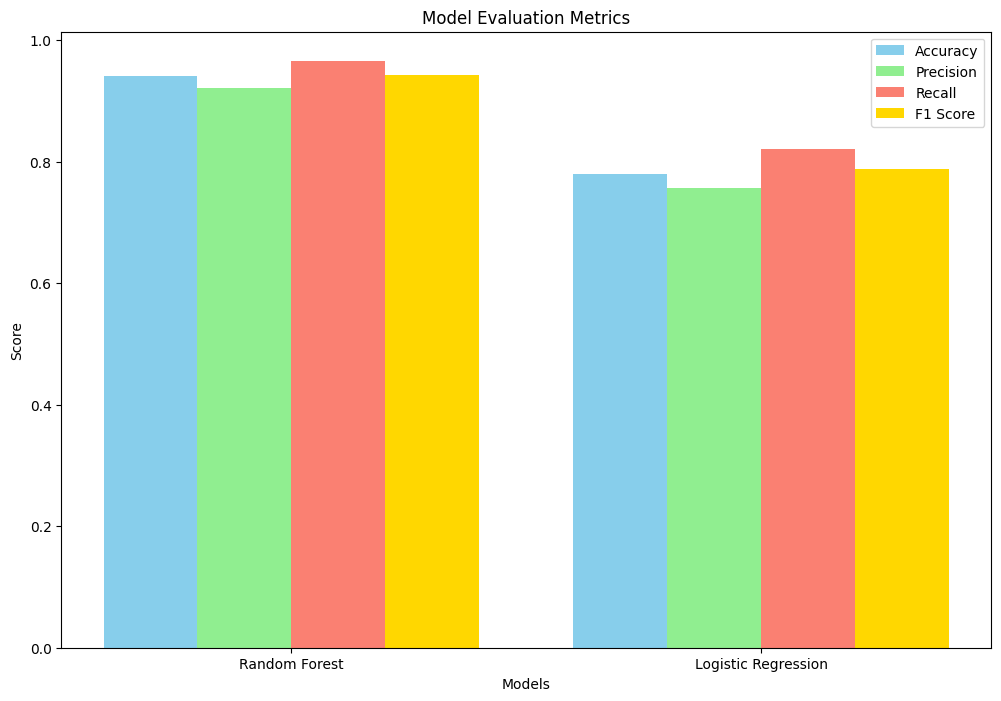

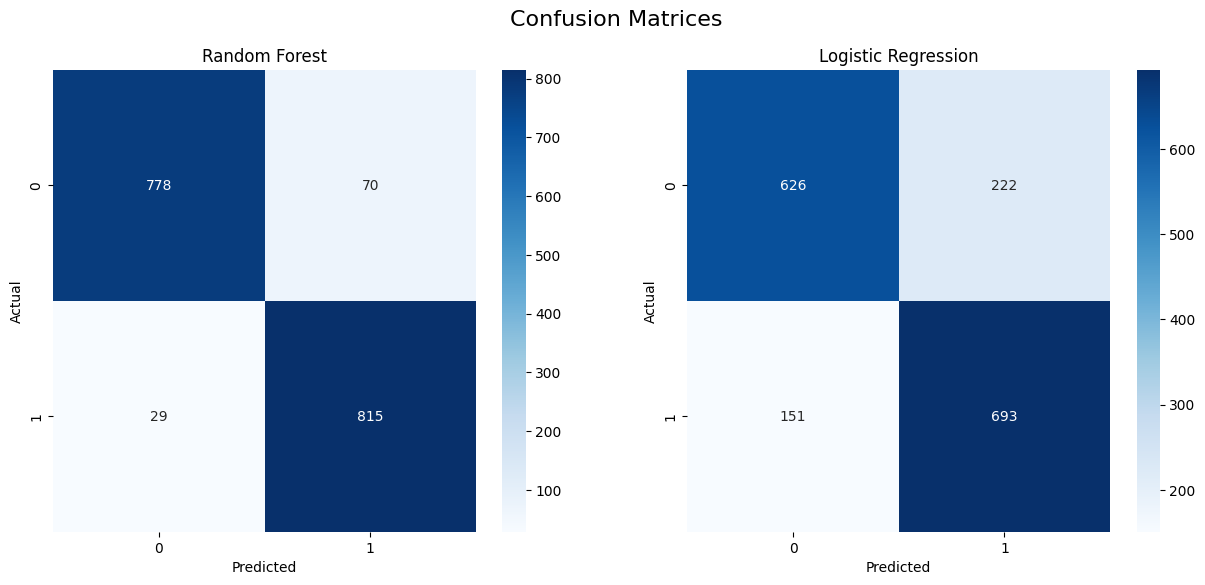

In [37]:
# Visualize the results
# Extract metrics for visualization
models = ['Random Forest', 'Logistic Regression']
accuracies = [rf_metrics_balanced['Accuracy'], lr_metrics_balanced['Accuracy']]
precisions = [rf_metrics_balanced['Precision'], lr_metrics_balanced['Precision']]
recalls = [rf_metrics_balanced['Recall'], lr_metrics_balanced['Recall']]
f1_scores = [rf_metrics_balanced['F1 Score'], lr_metrics_balanced['F1 Score']]

# Plot the evaluation metrics for both models
plt.figure(figsize=(12, 8))
x = range(len(models))

# Plot each metric as a bar chart
plt.bar(x, accuracies, width=0.2, label='Accuracy', color='skyblue', align='center') 
plt.bar([p + 0.2 for p in x], precisions, width=0.2, label='Precision', color='lightgreen', align='center') # Shifted by 0.2 for side-by-side comparison
plt.bar([p + 0.4 for p in x], recalls, width=0.2, label='Recall', color='salmon', align='center')
plt.bar([p + 0.6 for p in x], f1_scores, width=0.2, label='F1 Score', color='gold', align='center')

# Add labels, title, and legend
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Evaluation Metrics')
plt.xticks([p + 0.3 for p in x], models)
plt.legend()

# Display the plot
plt.show()

# Plot confusion matrices for both models
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Confusion Matrices', fontsize=16)

# Random Forest Confusion Matrix
sns.heatmap(rf_metrics_balanced['Confusion Matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Random Forest')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Logistic Regression Confusion Matrix
sns.heatmap(lr_metrics_balanced['Confusion Matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Logistic Regression')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

# Display the confusion matrices
plt.show()

### Model Evaluation Metrics Bar chart:
- Random Forest performs better across all metrics, indicating it handles the goal prediction task more effectively.

### Confusion Matrix:
- Random Forest: Correctly predicts a higher number of both successful and unsuccessful goal attempts.
- Logistic Regression: Slightly more misclassifications compared to Random Forest, especially in predicting unsuccessful goals.

## **FEATURES IMPORTANT**
- Now that we have Random Forest as the definitive models to use to answer the question. We can figure out what feature(s) are the most important in determining whether or not the play will goal or not goal.

In [38]:
# Get feature importances from the trained Random Forest model
importances = rf_model_balanced.feature_importances_
feature_names = X_balanced.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance for Random Forest')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

NameError: name 'X_balanced' is not defined

> ### **Final Insights**:
- `accelerate` and `DistanceCeil` are the 2 leading features in scoring a goal for a class (moveset) in a game of Rocket League.
- Actions like `jump`, `boost` combining with Measurements like `PlayerSpeed`, `BallSpeed` and `BallAcceleration` moderately affect the `goal` probability, indicating that the dynamics of the ball and player are crucial in determining goal success. 
- While Actions such as: going `slow`, turning `left`, `down`, `up`, `right`. Are the least of the player worries in scoring a goal. 

### **Why the Accuracy Scores in Quesstion 3 are lower than other Question?**
- **Differences in Features:** Question 3 focuses on features related to boost usage frequency and timing, such as boost frequency, accelerate, and Time.
- **Feature Importance and Influence:** In Question 3, features related to boost usage might exhibit more complex or subtle relationships with performance, making it harder for the model to achieve high accuracy.
- **Class Imbalance:** The model might be biased toward predicting majority classes. Minority classes are harder for the model to predict accurately, leading to lower performance on these classes.
- **Complexity of the Problem:** The task in Question 3 may be inherently more complex, as it involves analyzing boost usage timing and frequency, which can be situational and harder to model.

### **Conclusion:**
- Frequent and timely use of boost significantly enhances player performance, especially when combined with acceleration.
- Proper boost management helps players maintain high speed and make effective plays, contributing to their overall impact on team success.
- Mismanagement of boost, such as excessive boosting without strategic purpose, may hinder performance (e.g., lack of boost during critical moments).
- **Positive correlation with:**
  - **Acceleration (accelerate):** Suggests that players frequently use boost alongside acceleration to maintain or increase speed.
  - **Time (Time):** Indicates that boost usage increases as the match progresses.
- **Negative correlation with:**
  - **Sliding (slide):** Players who frequently use boost tend to avoid sliding, likely to maintain momentum.
  - **Downward Movement (down):** Boost usage reduces the need for downward maneuvers.
- **The most significant features affecting player performance are:**
- **Boost:** The frequency of boost usage is a major factor in performance.
- **Acceleration (accelerate):** Indicates that boosting combined with acceleration has a strong impact on maintaining speed and executing plays.
- **Time (Time):** Timing of boost usage during the match is crucial for performance.
- **Player Speed (PlayerSpeed) and Ball Speed (BallSpeed):** Maintaining high speed through boost usage is essential for effective gameplay.

## **Reflection:**
- Team reflection on the challenges faced during the project.

### Prompts for self-reflection:
- Challenges:
    + At first, the pre-processing steps encountered a problem which is that we missed read that data format and ended up having an unorganised and messed up dataframe.
    + Not being able to determined what model would be best to use for a dataset that has 2 types of feature (continuos numerical and static binary). 
    + Un-balanced dataset for Model training (between classes, target classes, etc.), required some research on balancing techniques which took some time (SMOTE, XGBoost, etc.)
    + Visualization of the dataframe are hard to read and understand (especially the box plot)
    + Identifying the timing of boost usage as a critical factor required careful analysis and multiple iterations to understand its impact on player performance.

- Experiences gained:
    + ALWAYS read the documentation throughly when using a pre-made dataset. This helps grasping the content and structure of the data much easier and waste much less time. 
    + Comparing models result to determined data quality as well as nature (linear or not).
    + Visualization are a must for comparision.
    + Clear and effective visualizations are crucial for comparing features, understanding correlations, and conveying insights.
    + Learned that boost management and acceleration timing are key elements that significantly influence player success in Rocket League.

- Room for Improvement:
    + Certain models have low Accuracy score, an upgrade/switch is needed or the dataframe need to be change. 
    + Explore advanced techniques to balance the dataset more effectively for improved training outcomes.
    + Incorporate dynamic visualizations (e.g., animated timelines) to better understand how boost usage changes during different phases of the game.
    + Perform more feature engineering to create new metrics, such as boost efficiency or boost-to-speed ratios, to improve model accuracy and insights.
    + Data Balancing: Use techniques like SMOTE to address class imbalance.
    + Advanced Models: Experiment with models like Gradient Boosting or Time-Series Analysis to capture temporal patterns in boost usage.

## **References:**
This section lists the materials and resources consulted for the project.

### Data usage:
1. Mathonat, R., et al., *A Behavioral Pattern Mining Approach to Model Player Skills in Rocket League*, IEEE CoG 2020.
2. GitHub Repository: [Rocket League Skills Detection](https://github.com/Romathonat/RocketLeagueSkillsDetection)
3. Documentation for Python libraries: pandas, matplotlib, seaborn.

### Models:
1. RandomForestClassifier: https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.RandomForestClassifier.html
2. LogisticRegression: https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html
3. Logistic Regression in Machine Learning: 
    + https://www.geeksforgeeks.org/understanding-logistic-regression/
    + https://machinelearningcoban.com/2017/01/27/logisticregression/

### Theory:
1. Why do we need data splitting? - https://www.linkedin.com/pulse/why-do-we-need-data-splitting-utkarsh-sharma/
2. Why 70/30 or 80/20 Relation Between Training and Testing Sets: A Pedagogical Explanation - https://typeset.io/papers/why-70-30-or-80-20-relation-between-training-and-testing-4qqruorjip

### Programming Technique:
1. SMOTE for Imbalanced Classification with Python - https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
2. Why do we choose random state as 42 very often? - https://www.kaggle.com/discussions/general/336747
3. Data Preprocessing: https://medium.com/@yogeshojha/data-preprocessing-75485c7188c4
2. Feature Scaling: https://scikit-learn.org/1.5/auto_examples/preprocessing/plot_scaling_importance.html
